### Topic Modeling with LDA

This is a project I did for a bank using LDA topic modeling.  I transcribed their interviews with several customers and performed topic modeling to identify key themes of importance to customers.  Then I scraped the bank's website and performed topic modeling.  The final steps of analysis were to compare topics from the website to what customers cared about.  My recommendations to the bank focused on ways to better communicate shared values to customers as a way to bring in new customers, sell more services and products to current customers, and maintain customer loyalty.

The transcription and webscraping steps are not included in this tutorial.

All of the data used in this project are available on the web; however, I am not sharing the data freely out of respect for the client.

### Preprocessing and File Management

In [1]:
# packages for analysis
import os
from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='pyLDAvis')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import numpy as np
import pandas as pd
import nltk.data
from nltk.util import bigrams 
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import collections
from collections import Counter
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

#### Save Website Text into a Hash

In [2]:
# Import data scraped from the Main Street Bank website.

path_to_data_directory = "c:/Users/h_lig/Documents/Data Science Classes/Archive/Natural Language Processing/Final Project/ProcessedData"

# Make a list of 84 integers.  These are the names of the text files. 
webpage_numbers = list(filter((0).__ne__, range(85)))

#Create hash
webpages_hash = dict.fromkeys(webpage_numbers)

# Iterate over the files and add to the hash
for pg in webpage_numbers:
    input_file_text = open(join(path_to_data_directory, str(pg)), encoding='utf-8', errors='ignore').read()
    webpages_hash[pg] = input_file_text

#### Process Website Text Data

In [3]:
# setup a new hash to store the results in and create instances of classes
processed_hash = webpages_hash.copy()
bigram_hash = webpages_hash.copy()
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
treebank_tokenizer = TreebankWordTokenizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

In [4]:
# iterate through the keys, i.e. document ids, in the hash to pull out the stored text and process
# also segment sentences, tokenize words, drop stopwords and puncution, and lemmatize
for key in webpages_hash.keys():
    webtext = webpages_hash[key]
    punkt_sentences = sentence_tokenizer.tokenize(webtext)
    sentences_words = [treebank_tokenizer.tokenize(sentence) for sentence in punkt_sentences] #segment sentences
    all_tokens = [word for sentence in sentences_words for word in sentence] #tokenize words
    tokens = [word.lower() for word in all_tokens]# make lowercase
    content = [w for w in tokens if w not in stop_words] #drop stopwords
    content2 = [words for words in content if words.isalpha()] #drop punctuation
    content3 = content2.copy()
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in content2] #lemmatize
    processed_hash[key] = lemmatized_words

In [5]:
# Example:  First 20 processed words from a webpage about commercial real estate.
processed_hash[2][0:20]

['reward',
 'owning',
 'commercial',
 'real',
 'estate',
 'significant',
 'path',
 'success',
 'always',
 'forthcoming',
 'maybe',
 'prepared',
 'remodel',
 'expand',
 'existing',
 'business',
 'maybe',
 'ready',
 'build',
 'new']

#### Save Customer Text into a Hash

In [6]:
# Import data transcribed from the Main Street Bank customers' YouTube videos.

path_to_data_directory2 = "c:/Users/h_lig/Documents/Data Science Classes/Archive/Natural Language Processing/Final Project/Customers"

# List of file names
customers = ['Bakery','Brewery','Dentist','Lawyer','PaymentServices','Pottery']

#Create hash
customers_hash = dict.fromkeys(customers)

# Iterate over the files and add to the hash
for comp in customers:
    input_file_text2 = open(join(path_to_data_directory2, comp), encoding='utf-8', errors='ignore').read()
    customers_hash[comp] = input_file_text2

#### Process Bank Customer Transcript Data

In [7]:
# create instances of classes
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
treebank_tokenizer = TreebankWordTokenizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

In [8]:
# setup new hashes to store the results in and preprocess
p_customers_hash = customers_hash.copy()
cust_bigram_hash = customers_hash.copy()
for key in customers_hash.keys():
    text = customers_hash[key]
    punkt_sentences = sentence_tokenizer.tokenize(text)
    sentences_words = [treebank_tokenizer.tokenize(sentence) for sentence in punkt_sentences] #segment sentences
    all_tokens = [word for sentence in sentences_words for word in sentence] #tokenize words
    tokens = [word.lower() for word in all_tokens]# make lowercase   
    content = [w for w in all_tokens if w.lower() not in stop_words] #drop stopwords
    content2 = [words for words in content if words.isalpha()] #drop punctuation
    content3 = content2.copy()
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in content2] #lemmatize
    p_customers_hash[key] = lemmatized_words
    #bigrams = list(nltk.bigrams(content3))
    #cust_bigram_hash[key] = bigrams

In [9]:
# First 15 processed words from a customer interview.
p_customers_hash['Bakery'][0:15]

['first',
 'thing',
 'getting',
 'loan',
 'purchase',
 'business',
 'rare',
 'get',
 'opportunity',
 'talk',
 'president',
 'bank',
 'able',
 'talk',
 'directly']

## Analysis

### Compare customer and website vocabulary using Jacardian & Cosine Similarity

In [10]:
def jacardian(website_data, customer_data):
    words_in_website_not_in_customer = set(website_data)
    words_in_customer_not_in_website = set(customer_data)
    words_in_both = words_in_website_not_in_customer.intersection(words_in_customer_not_in_website)
    
    jacardian = float(len(words_in_both)) / (len(words_in_website_not_in_customer) + len(words_in_customer_not_in_website) - len(words_in_both))
    
    return jacardian

In [11]:
def cosine_similarity(website_data, customer_data):
    dictionary = {}

    for word in website_data:
        if word not in dictionary.keys():
            dictionary[word] = word

    for word in customer_data:
        if word not in dictionary.keys():
            dictionary[word] = word
            
    vectorizer = CountVectorizer(vocabulary=dictionary.values())

    website_vector = vectorizer.transform([" ".join(website_data)]).toarray()[0]
    
    customer_vector = vectorizer.transform([" ".join(customer_data)]).toarray()[0]
                                  
    dot_product = np.dot(website_vector, customer_vector)
    norm_1 = np.linalg.norm(website_vector)
    norm_2 = np.linalg.norm(customer_vector)
    cosine_similarity = dot_product / (norm_1 * norm_2)
    return cosine_similarity

In [12]:
# create dataframes to store table data
df_jacard = pd.DataFrame(data=0,index=(list(filter((0).__ne__, range(85)))), columns=customers, dtype=float)
df_cosinesim = pd.DataFrame(data=0,index=(list(filter((0).__ne__, range(85)))), columns=customers, dtype=float)

In [13]:
# compare the text from each webpage to the customer text, find jacardian distance, find cosine similarity, fill dataframe with values
for doc_key in processed_hash.keys():
    for comp_key in p_customers_hash.keys():
        df_jacard.at[doc_key, comp_key] = jacardian(processed_hash[doc_key], p_customers_hash[comp_key])
        df_cosinesim.at[doc_key, comp_key] = cosine_similarity(processed_hash[doc_key], p_customers_hash[comp_key])

In [14]:
# Make copy of df_jacard to manipulate
df_jacard2 = df_jacard.copy(deep=True)
df_jacard2['Webpage'] = df_jacard2.index

In [15]:
# Make copy of df_cosinesim to manipulate
df_cosinesim2 = df_cosinesim.copy(deep=True)
df_cosinesim2['Webpage'] = df_cosinesim2.index

#### Example Heatmap for Jacardian Distance

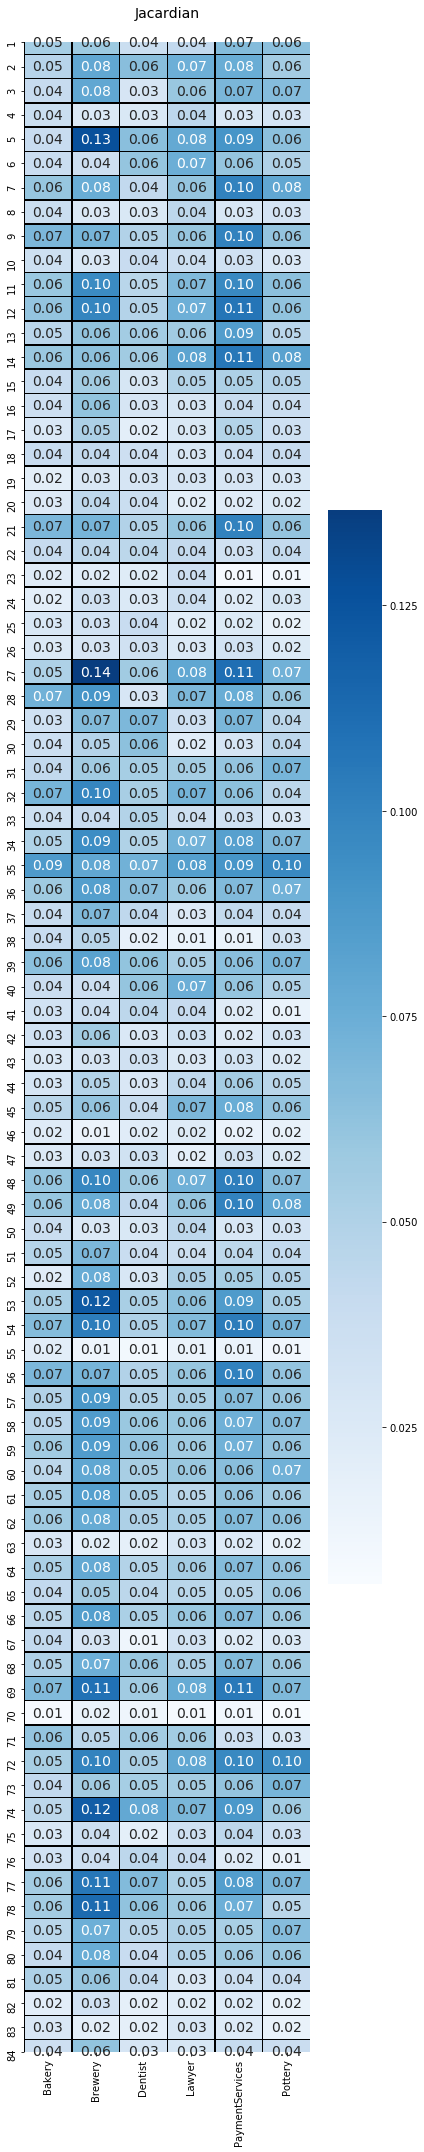

In [16]:
# Get heat map of Jacardian
plt.figure(figsize=(6,30))
sns.heatmap(df_jacard,
            cmap='Blues',
            center=.075,
            cbar=True,
            annot=True,
            square=False,
            linewidths=0.5, 
            linecolor='black',
            fmt='.2f',
            annot_kws={'size': 14}
           )
plt.title('Jacardian', pad=25, fontsize=14)

# Show heat map
plt.tight_layout()
plt.show()

#### Example Dataframe of Top Sites that Match Customers using Cosine Similarity

In [17]:
# Create dataframe to show top results by customer
top1 = pd.DataFrame(data=0, index=(list(filter((0).__ne__, range(1)))), columns=['Customer','Webpage','Cosine Similarity'])

for customer in customers:
    dfX = df_cosinesim2.sort_values(by=customer, ascending=False)
    dfX = dfX.head()
    dfX['Cosine Similarity'] = dfX[customer]
    dfX = dfX[['Webpage','Cosine Similarity']]
    dfX.insert(0,'Customer',customer)
    top1 = top1.append(dfX) 

In [18]:
# Copy for use below
topC = top1.copy(deep=True)

In [19]:
# Sort and reindex, showing each customer's top 5 webpages
top1.reset_index(drop=True, inplace=True)

In [20]:
# Sort by Cosine Similarity score in descending order
topC.sort_values(by=['Cosine Similarity'], ascending=False, inplace=True)
topC.reset_index(drop=True, inplace=True)
topC[0:10]

,Customer,Webpage,Cosine Similarity
0,Lawyer,65,0.522625
1,Lawyer,66,0.489221
2,Lawyer,59,0.481433
3,Lawyer,71,0.469895
4,Lawyer,82,0.454074
5,PaymentServices,27,0.452667
6,PaymentServices,5,0.404061
7,PaymentServices,74,0.403471
8,Dentist,65,0.401999
9,PaymentServices,53,0.394294


#### Example of Top Websites across customers, taking both Jacardian and Cosine Similarity measures into account

In [21]:
# Create dataframe to show top results by customer using Jacardian
top2 = pd.DataFrame(data=0, index=(list(filter((0).__ne__, range(1)))), columns=['Customer','Webpage','Jacardian Index'])

for customer in customers:
    dfX = df_jacard2.sort_values(by=customer, ascending=False)
    dfX = dfX.head()
    dfX['Jacardian Index'] = dfX[customer]
    dfX = dfX[['Webpage','Jacardian Index']]
    dfX.insert(0,'Customer',customer)
    top2 = top2.append(dfX)
    
# Sort and reindex, showing each customer's top 5 webpages
top2.reset_index(drop=True, inplace=True)

In [22]:
# Concatinate the top 5 websites for each customer as measured by Jacardian and Cosine Similarity
combined = pd.concat([top1, top2], axis=0, join='outer', sort=False)
combined.reset_index(drop=True, inplace=True)

In [23]:
# Sort top sites by matches to customers in descending order
topsites = combined.groupby(['Webpage']).size()
topsites.sort_values(ascending=False, inplace=True)
topsites.to_frame(name='Customer Count')
topsites.head(10)

Webpage
27    6
5     4
65    4
74    4
35    4
59    4
14    3
61    3
53    3
66    3
dtype: int64

In [24]:
# Not surprisingly, the webpage most relevant to the customers is the business banking page.
webpages_hash[27][0:202]

'Imagine a business banking relationship where you matter most of all. Whether your business is well established, seasoned, or just starting out, your business must have a supportive and reliable banking'

### Compare Customers

In [25]:
customer_compJ = pd.DataFrame(data=0, index=customers, columns=customers, dtype=float)
customer_compC = pd.DataFrame(data=0, index=customers, columns=customers, dtype=float)

In [26]:
# compare each customer to each other customer, find jacardian distance, find cosine similarity, fill dataframe with values
for key1 in p_customers_hash.keys():
    for key2 in p_customers_hash.keys():
        customer_compJ.at[key1, key2] = jacardian(p_customers_hash[key1], p_customers_hash[key2])
        customer_compC.at[key1, key2] = cosine_similarity(p_customers_hash[key1], p_customers_hash[key2])

#### Example of Cosine Similarity between Customers

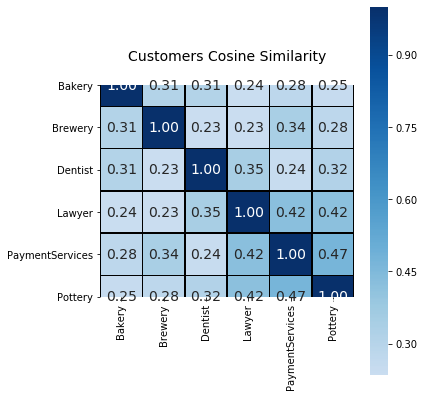

In [27]:
# Get heat map of Cosine Similarity
plt.figure(figsize=(6,6))
sns.heatmap(customer_compC,
            cmap='Blues',
            center=.5,
            cbar=True,
            annot=True,
            square=True,
            linewidths=0.5, 
            linecolor='black',
            fmt='.2f',
            annot_kws={'size': 14}
           )
plt.title('Customers Cosine Similarity', pad=25, fontsize=14)

# Show heat map
plt.tight_layout()
plt.show()

### LDA using gensim

1. Websites

In [28]:
# Make list of lists containing all the websites' tokenized text
allwebtokens = []
for key in processed_hash.keys():
    allwebtokens.append(processed_hash[key])

In [29]:
# Creating the term dictionary of the corpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(allwebtokens)
dictionary.filter_extremes(no_below=2, no_above=0.75, keep_n=2000)

In [30]:
# Converting corpus into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(item) for item in allwebtokens]

#### About the model parameters:

chunksize = How many documents are processed at a time in the training algorithm

passes = How often we train the model on the entire corpus, i.e. epochs

iterations = How often we repeat a particular loop over each document

alpha = Default is 0.1.  Controls the prior distribution over topic weights in each document; a higher alpha makes the document preferences "smoother" over topics.

    When alpha is low, most of the weight in the topic distribution for this article goes to a single topic.  When it is high, the weight is much more evenly distributed across the topics.

eta = 2  # Default is 0.1.  Controls the prior distribution over word weights in each topic; a higher eta makes the topic preferences "smoother" over words.

    When eta is low, most of the weight in the topic is placed on the top words and less weight is placed on the bottom words for each topic (i.e., topics are composed of few words).  When eta is high, relatively less weight is placed on the top words and more weight on the bottom words, so it is smoothed out.

In [31]:
# Creating the object for LDA model using gensim library
lda = gensim.models.ldamodel.LdaModel

# Set training parameters
num_topics = 10
chunksize = 15
passes = 200
iterations = 50
gamma_threshold=0.01
alpha = 0.1
eta = 0.1

# Train the LDA model on the document term matrix.
ldamodel = lda(corpus = doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
               chunksize=chunksize, alpha=alpha, eta=eta, iterations=iterations, update_every=1, 
               passes=passes, gamma_threshold=gamma_threshold, random_state=0)

In [32]:
pprint(ldamodel.print_topics(num_topics=10, num_words=5))

[(0,
  '0.084*"card" + 0.060*"apple" + 0.030*"merchant" + 0.030*"device" + '
  '0.030*"pay"'),
 (1,
  '0.075*"account" + 0.065*"check" + 0.053*"deposit" + 0.029*"overdraft" + '
  '0.028*"withdrawal"'),
 (2,
  '0.033*"account" + 0.031*"cash" + 0.025*"kasasa" + 0.023*"checking" + '
  '0.021*"balance"'),
 (3,
  '0.048*"mortgage" + 0.035*"home" + 0.022*"u" + 0.013*"stay" + '
  '0.011*"simplify"'),
 (4,
  '0.001*"entire" + 0.001*"brings" + 0.001*"top" + 0.001*"unless" + '
  '0.001*"unlawful"'),
 (5,
  '0.096*"share" + 0.054*"continue" + 0.039*"thousand" + 0.035*"mnsb" + '
  '0.031*"value"'),
 (6,
  '0.018*"business" + 0.017*"million" + 0.016*"first" + 0.013*"loan" + '
  '0.011*"solution"'),
 (7,
  '0.078*"payment" + 0.060*"auto" + 0.038*"loan" + 0.025*"please" + 0.025*"u"'),
 (8,
  '0.043*"mobile" + 0.036*"q" + 0.027*"account" + 0.017*"device" + '
  '0.015*"kasasa"'),
 (9,
  '0.037*"customer" + 0.034*"service" + 0.024*"account" + 0.022*"may" + '
  '0.018*"payment"')]


Website Inferred Topics:
    1. card, apple, merchant, device, pay - apple pay information for merchants
    2. account, check, deposit, overdraft, withdrawal - checking account overdraft info
    3. account, cash, kasasa, checking, balance - checking account info
    4. mortgage, home, u, stay, simplify - mortgages
    5. entire, brings, top, unless, unlawful - regulation
    6. share, continue, thousand, mnsb, value - bank financials
    7. business, million, first, loan, solution - business loans
    8. payment, auto, loan, please, u - auto loans
    9. mobile, q, account, device, kasasa - mobile banking
    10. customer, service, account, may, payment - customer service info

In [33]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=allwebtokens, corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v', topn=10)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.564134474888363


Website Visualizations

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(vis)

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.  On the right, the words that make up Topic 10 are listed.

2. Customers

In [35]:
# Make list of lists containing all the websites' text - i.e., the corpus
allcustomertokens = []
for key in p_customers_hash.keys():
    allcustomertokens.append(p_customers_hash[key])

# Creating the term dictionary of the corpus, where every unique term is assigned an index.
dictionary2 = corpora.Dictionary(allcustomertokens)
dictionary2.filter_extremes(no_below=2, no_above=0.90, keep_n=500)

# Converting corpus into Document Term Matrix using dictionary prepared above.
doc_term_matrix2 = [dictionary2.doc2bow(item) for item in allcustomertokens]

In [36]:
# Set training parameters
num_topics = 5
chunksize = 1
passes = 100
iterations = 10
gamma_threshold=0.1
alpha = 0.1
eta = 0.5

# Train the LDA model on the document term matrix.
ldacustmodel = lda(corpus = doc_term_matrix2, id2word=dictionary2, num_topics=num_topics, 
               chunksize=chunksize, alpha=alpha, eta=eta, iterations=iterations, update_every=1, 
               passes=passes, gamma_threshold=gamma_threshold, random_state=1)

In [37]:
pprint(ldacustmodel.print_topics(num_topics=5, num_words=5))

[(0,
  '0.007*"practice" + 0.007*"much" + 0.007*"office" + 0.007*"check" + '
  '0.007*"needed"'),
 (1,
  '0.040*"made" + 0.031*"community" + 0.026*"part" + 0.021*"new" + '
  '0.021*"loan"'),
 (2,
  '0.036*"thing" + 0.036*"lot" + 0.030*"time" + 0.030*"Virginia" + '
  '0.023*"account"'),
 (3,
  '0.044*"get" + 0.043*"year" + 0.035*"people" + 0.019*"good" + 0.019*"old"'),
 (4,
  '0.036*"get" + 0.035*"need" + 0.031*"like" + 0.026*"person" + 0.024*"right"')]


In [38]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldacustmodel, texts=allcustomertokens, corpus=doc_term_matrix2, dictionary=dictionary2, coherence='c_v', topn=10)
coherence_lda_cust = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda_cust)

Coherence Score:  0.4825933796422629


Customer Inferred Topics:
    1. practice, much, office, check, needed - ability to deposit checks in office was much needed
    2. made, community, part, new, loan - loan enabled being part of the community
    3. thing, lot, time, Virginia, account - local service saves time
    4. get, year, people, good, old - like the good old times
    5. get, need, like, person, right - personal interaction, getting to the right person

Customer Visualizations

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldacustmodel, doc_term_matrix2, dictionary2, sort_topics=False)
pyLDAvis.display(vis)